In [1]:
import pretty_midi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import sys
import os
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

print("Python version")
print(sys.version)
print(sys.version_info)

print(f"\nPytorch version {torch.__version__}")

# Use CUDA if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Python version
3.11.10 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:26) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=11, micro=10, releaselevel='final', serial=0)

Pytorch version 2.5.1


In [2]:
# parse music folder to identify .mid files under each composer
dir_name = 'music'

artist_list = []
file_list = {}

directory_path = Path('music')
for file_path in directory_path.iterdir():
    if file_path.is_file():
        print(file_path)
    else:
        artist_list.append(file_path.name)

print(artist_list)

for artist_name in artist_list:
    file_list[artist_name] = []
    directory_path = Path(os.path.join('music', artist_name))
    for file_path in directory_path.iterdir():
        if file_path.is_file():
            if '.mid' in str(file_path):
                file_list[artist_name].append(str(file_path))
        else:
            directory_path_sub = Path(os.path.join('music', artist_name, file_path.name))
            for file_path2 in directory_path_sub.iterdir():
                if file_path2.is_file():
                    if '.mid' in str(file_path2):
                        file_list[artist_name].append(str(file_path2))
                else:
                    directory_path_sub_sub = Path(os.path.join('music', artist_name, file_path.name, file_path2.name))
                    for file_path3 in directory_path_sub_sub.iterdir():
                        if file_path3.is_file():
                            if '.mid' in str(file_path3):
                                file_list[artist_name].append(str(file_path3))
                        else:
                            print(file_path3)

for artist_name in artist_list:
    print(f"{artist_name} number of midi files={len(file_list[artist_name])}")

['Bach', 'Beethoven', 'Chopin', 'Mozart']
Bach number of midi files=369
Beethoven number of midi files=213
Chopin number of midi files=136
Mozart number of midi files=257


In [3]:
# convert .mid file to numerical matrix (piano roll)
def midi_to_piano_roll(midi_file_path, fs=100, min_pitch=0, max_pitch=127):

    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    except Exception as e:
        print(f"Error loading MIDI file {midi_file_path}: {e}")
        return None

    # Get piano roll for all instruments
    piano_roll = midi_data.get_piano_roll(fs=fs)

    # Crop to desired pitch range
    piano_roll = piano_roll[min_pitch:max_pitch+1, :]

    # Normalize velocity 
    piano_roll = piano_roll / 127.0

    return piano_roll

In [5]:
# compute pitch class histogram and note density features
def compute_pitch_class_histogram_and_density(midi_data, sequence_start, sequence_end):
    notes = []
    for instrument in midi_data.instruments:
        notes.extend(instrument.notes)

    seq_notes = [note for note in notes if sequence_start <= note.start < sequence_end]

    pitch_classes = [note.pitch % 12 for note in seq_notes]
    histogram = np.zeros(12)
    for pc in pitch_classes:
        histogram[pc] += 1
    if histogram.sum() > 0:
        histogram = histogram / histogram.sum()

    duration = sequence_end - sequence_start
    density = len(seq_notes) / duration if duration > 0 else 0

    return histogram, density

In [6]:
def extract_additional_features(sequence):
    # 1. Pitch class histogram
    pitch_classes = np.arange(sequence.shape[1]) % 12
    histogram = np.zeros(12)
    for i in range(12):
        histogram[i] = sequence[:, pitch_classes == i].sum()
    histogram /= (sequence.sum() + 1e-5) 

    # 2. Note density
    note_density = np.mean(sequence.sum(axis=1)) 

    return np.concatenate([histogram, [note_density]])  

In [7]:
# transform raw .mid files to sequences
# adding transposition augmentation
def prepare_data_for_lstm(sequence_length, fs=100, min_pitch=21, max_pitch=108,overlap=0, transpose_range=(-2, 2)): 
    all_sequences = []
    all_labels = []
    label_map = {}

    n_pitches = max_pitch - min_pitch + 1

    # start label ID at zero
    current_label = 0

    for artist_name in artist_list:
        print(f"Starting {artist_name} with {len(file_list[artist_name])} midi files")
        midi_files = file_list[artist_name]
        label_map[current_label] = artist_name
        
        for midi_file in midi_files:
                piano_roll = midi_to_piano_roll(str(midi_file), fs=fs, min_pitch=min_pitch, max_pitch=max_pitch)
                if piano_roll is None:
                    continue

                # Transpose piano_roll to (time_steps, pitches) for LSTM
                piano_roll = piano_roll.T

                # Segment the piano roll into sequences
                num_time_steps = piano_roll.shape[0]
                step_size = sequence_length - overlap
                
                for i in range(0, num_time_steps - sequence_length + 1, step_size):
                    original_seq = piano_roll[i:i + sequence_length, :]
                    # transposition augmentation
                    for shift in range(transpose_range[0], transpose_range[1] + 1):
                        if shift == 0:
                            transposed_seq = original_seq
                        else:
                            transposed_seq = np.roll(original_seq, shift, axis=1)

                            if shift > 0:
                                transposed_seq[:, :shift] = 0
                            else:
                                transposed_seq[:, shift:] = 0

                        features = extract_additional_features(transposed_seq)
                        features = np.repeat(features[np.newaxis, :], sequence_length, axis=0)
                        combined_input = np.concatenate([transposed_seq, features], axis=1)
                        
                        all_sequences.append(combined_input)
                        all_labels.append(current_label)

        if not all_sequences:
            print("No sequences processed. Check your MIDI file paths and parameters.")
            return None, None
        # Increment label Id
        current_label += 1

    X = np.array(all_sequences)
    y = np.array(all_labels)

    print(f"\nTotal sequences: {X.shape[0]}")
    print(f"Input shape (X): {X.shape} (samples, sequence_length, pitches)")
    print(f"Output shape (y): {y.shape} (samples, num_classes)")

    return X, y, label_map

In [8]:
# --- Configuration ---
SEQUENCE_LENGTH = 100 # Number of time steps in each input sequence (corresponds to 1 second if fs=100)
FS = 10 # temporal resolution, increasing fs captures finer rhythmic differences
MIN_PITCH = 21 # A0
MAX_PITCH = 108 # C8
OVERLAP = 0 # Overlap between sequences to capture more context

# --- 1. Prepare Data ---
print("Preparing data...")
X, y, label_map = prepare_data_for_lstm(sequence_length=SEQUENCE_LENGTH, fs=FS, min_pitch=MIN_PITCH, max_pitch=MAX_PITCH, overlap=OVERLAP)

Preparing data...
Starting Bach with 369 midi files


C:\Users\Donva\anaconda3\Lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Starting Beethoven with 213 midi files
Error loading MIDI file music\Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Starting Chopin with 136 midi files
Starting Mozart with 257 midi files
Error loading MIDI file music\Mozart\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2

Total sequences: 165720
Input shape (X): (165720, 100, 101) (samples, sequence_length, pitches)
Output shape (y): (165720,) (samples, num_classes)


In [9]:
# ouput label mapping for visibility
print("\nLabel to Composer Mapping:")
for label, composer in label_map.items():
    print(f"  Label {label}: {composer}")


Label to Composer Mapping:
  Label 0: Bach
  Label 1: Beethoven
  Label 2: Chopin
  Label 3: Mozart


In [10]:
# CNN-LSTM hyrbid model
class CNNLSTMClassifier(nn.Module):
    def __init__(self, input_size, conv_out_channels, kernel_size,
                 lstm_hidden_size, lstm_num_layers, output_size,
                 dropout_prob=0.5, bidirectional=True):
        super(CNNLSTMClassifier, self).__init__()

        self.conv1d = nn.Conv1d(in_channels=input_size, 
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

        lstm_input_size = conv_out_channels
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size=lstm_input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=lstm_num_layers,
                            batch_first=True,
                            dropout=dropout_prob if lstm_num_layers > 1 else 0,
                            bidirectional=bidirectional)
        
        fc_input_size = lstm_hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_input_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) 
        x = self.conv1d(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1) 

        h0 = torch.zeros(self.lstm.num_layers * (2 if self.bidirectional else 1),
                         x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers * (2 if self.bidirectional else 1),
                         x.size(0), self.lstm.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [11]:
# create custom dataset
class CustomDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [12]:
# Hyperparameters
num_layers = 2
hidden_size = 64
input_size = X.shape[2]
output_size = len(artist_list)

#split sequences into train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"Dataset sizes: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# Convert to tensors
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)

X_val = torch.from_numpy(X_val).float().to(device)
y_val = torch.from_numpy(y_val).long().to(device)

X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

# Create DataLoaders
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dataset sizes: Train=116004, Val=24858, Test=24858


In [14]:
# initialize CNN-LSTM Model
model = CNNLSTMClassifier(
    input_size=X.shape[2],     
    conv_out_channels=64,
    kernel_size=3,
    lstm_hidden_size=64,
    lstm_num_layers=2,
    output_size=len(artist_list),
    dropout_prob=0.5,
    bidirectional=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# train LSTM Model
num_epochs = 30
train_loss_history = []
val_loss_history = []

print("\n--- Training Model ---")
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train() 
    running_loss = 0.0
    for batch_sequences, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_sequences.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)

    # --- Validation Phase ---
    model.eval() 
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad(): 
        for val_sequences, val_labels in val_loader:
            val_outputs = model(val_sequences)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_sequences.size(0)

            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100 * correct_val / total_val

    train_loss_history.append(epoch_train_loss)
    val_loss_history.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')


--- Training Model ---
Epoch 1/30, Train Loss: 1.1452, Val Loss: 1.0128, Val Acc: 55.48%
Epoch 2/30, Train Loss: 0.9529, Val Loss: 0.8541, Val Acc: 64.62%
Epoch 3/30, Train Loss: 0.8386, Val Loss: 0.7775, Val Acc: 67.86%
Epoch 4/30, Train Loss: 0.7647, Val Loss: 0.7114, Val Acc: 70.35%
Epoch 5/30, Train Loss: 0.7174, Val Loss: 0.6968, Val Acc: 70.46%
Epoch 6/30, Train Loss: 0.6836, Val Loss: 0.6511, Val Acc: 73.16%
Epoch 7/30, Train Loss: 0.6563, Val Loss: 0.6405, Val Acc: 73.48%
Epoch 8/30, Train Loss: 0.6277, Val Loss: 0.6213, Val Acc: 74.60%
Epoch 9/30, Train Loss: 0.6040, Val Loss: 0.5855, Val Acc: 76.25%
Epoch 10/30, Train Loss: 0.5813, Val Loss: 0.5758, Val Acc: 76.21%
Epoch 11/30, Train Loss: 0.5654, Val Loss: 0.5756, Val Acc: 76.23%
Epoch 12/30, Train Loss: 0.5487, Val Loss: 0.5496, Val Acc: 77.48%
Epoch 13/30, Train Loss: 0.5322, Val Loss: 0.5309, Val Acc: 78.49%
Epoch 14/30, Train Loss: 0.5188, Val Loss: 0.5346, Val Acc: 77.87%
Epoch 15/30, Train Loss: 0.5039, Val Loss: 0.52

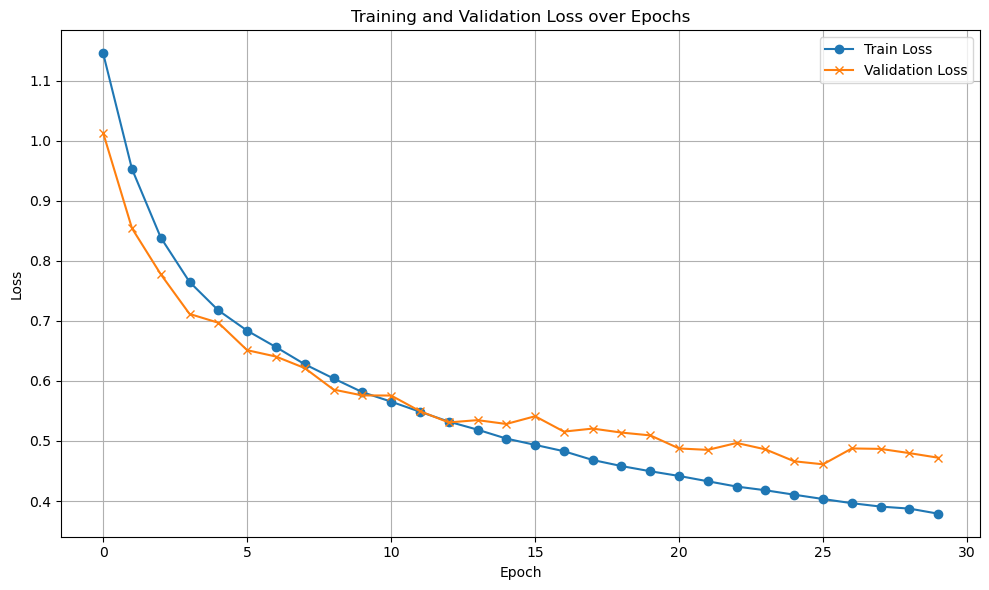

In [16]:
# plot training loss and validation loss to visualize optimal epochs for training
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# run model against test holdout data
print("\n--- Evaluating Model on Test Set ---")
model.eval()
test_running_loss = 0.0
correct_test = 0
total_test = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for test_sequences, test_labels in test_loader:
        test_outputs = model(test_sequences)
        test_loss = criterion(test_outputs, test_labels)
        test_running_loss += test_loss.item() * test_sequences.size(0)

        _, predicted = torch.max(test_outputs.data, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
test_loss = test_running_loss / total_test

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')


--- Evaluating Model on Test Set ---
Test Loss: 0.4822
Test Accuracy: 81.68%


In [18]:
# output classification report on model evaluation
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[label_map[i] for i in sorted(label_map)]))


Classification Report:
              precision    recall  f1-score   support

        Bach       0.89      0.91      0.90      7380
   Beethoven       0.84      0.70      0.76      7704
      Chopin       0.85      0.78      0.81      2200
      Mozart       0.73      0.85      0.79      7574

    accuracy                           0.82     24858
   macro avg       0.83      0.81      0.82     24858
weighted avg       0.82      0.82      0.82     24858



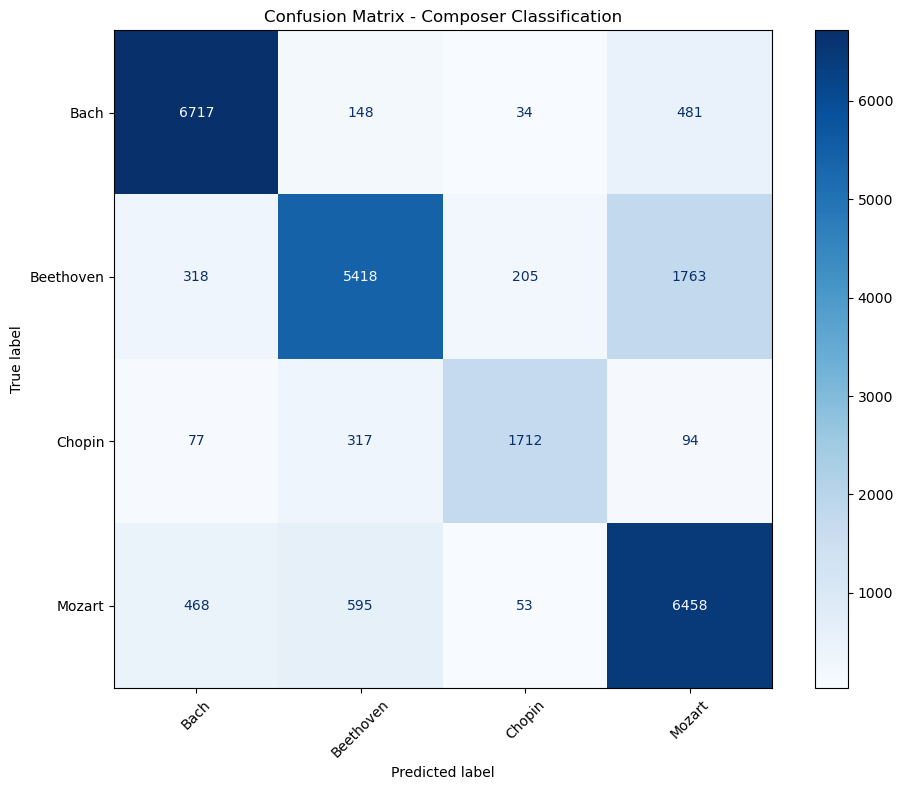

In [19]:
# output confusion matrix on model evaluation
cm = confusion_matrix(all_labels, all_preds)
class_names = [label_map[i] for i in sorted(label_map)]

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45, ax=plt.gca())
plt.title("Confusion Matrix - Composer Classification")
plt.grid(False)
plt.tight_layout()
plt.show()

In [20]:
# output model evaluation on test data by composer
print("\n--- Evaluating Model on Test Set (Per Composer) ---")
model.eval()
test_running_loss = 0.0
correct_test = 0
total_test = 0

all_preds = []
all_labels = []

# Initialize per-class counters
num_classes = len(label_map)
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for test_sequences, test_labels in test_loader:
        test_outputs = model(test_sequences)
        test_loss = criterion(test_outputs, test_labels)
        test_running_loss += test_loss.item() * test_sequences.size(0)

        _, predicted = torch.max(test_outputs.data, 1)

        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()

        # Store for confusion matrix/classification report
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(test_labels.cpu().numpy())

        # Update per-class accuracy counts
        for i in range(len(test_labels)):
            label = test_labels[i].item()
            pred = predicted[i].item()
            class_total[label] += 1
            if pred == label:
                class_correct[label] += 1

# Overall metrics
test_accuracy = 100 * correct_test / total_test
test_loss = test_running_loss / total_test
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Per-class (composer) accuracy
print("\nPer-Composer Accuracy:")
for i in range(num_classes):
    composer = label_map[i]
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f"  {composer:15}  Accuracy: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")
    else:
        print(f"  {composer:15}  No test samples.")


--- Evaluating Model on Test Set (Per Composer) ---
Test Loss: 0.4822
Test Accuracy: 81.68%

Per-Composer Accuracy:
  Bach             Accuracy: 91.02% (6717/7380)
  Beethoven        Accuracy: 70.33% (5418/7704)
  Chopin           Accuracy: 77.82% (1712/2200)
  Mozart           Accuracy: 85.27% (6458/7574)
